# Confirm TensorFlow can see the GPU

Simply select "GPU" in the Accelerator drop-down in Notebook Settings (either through the Edit menu or the command palette at cmd/ctrl-shift-P).

In [1]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# Observe TensorFlow speedup on GPU relative to CPU

This example constructs a typical convolutional neural network layer over a
random image and manually places the resulting ops on either the CPU or the GPU
to compare execution speed.

In [0]:
import tensorflow as tf
import timeit

# See https://www.tensorflow.org/tutorials/using_gpu#allowing_gpu_memory_growth
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

with tf.device('/cpu:0'):
  random_image_cpu = tf.random_normal((100, 100, 100, 3))
  net_cpu = tf.layers.conv2d(random_image_cpu, 32, 7)
  net_cpu = tf.reduce_sum(net_cpu)

with tf.device('/gpu:0'):
  random_image_gpu = tf.random_normal((100, 100, 100, 3))
  net_gpu = tf.layers.conv2d(random_image_gpu, 32, 7)
  net_gpu = tf.reduce_sum(net_gpu)

sess = tf.Session(config=config)

# Test execution once to detect errors early.
try:
  sess.run(tf.global_variables_initializer())
except tf.errors.InvalidArgumentError:
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise

def cpu():
  sess.run(net_cpu)
  
def gpu():
  sess.run(net_gpu)
  
# Runs the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

sess.close()

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
9.321829462000096
GPU (s):
2.130654915999912
GPU speedup over CPU: 4x


# Setting up

In [2]:
!pip install librosa
!apt-get install ffmpeg

    100% |████████████████████████████████| 1.6MB 16.2MB/s 
    100% |████████████████████████████████| 327kB 20.4MB/s 
    100% |████████████████████████████████| 3.2MB 11.4MB/s 
    100% |████████████████████████████████| 16.1MB 2.7MB/s 
  Running setup.py bdist_wheel for librosa ... - \ done
  Stored in directory: /root/.cache/pip/wheels/18/b8/10/f0f8f6ac60668a5cd75596cf14c25bb6b3ea1ecd815f058b7e
  Running setup.py bdist_wheel for audioread ... - done
  Stored in directory: /root/.cache/pip/wheels/53/02/90/7b5c4081b7470c550ab605f600bad237dde12a6b8999b11f50
  Running setup.py bdist_wheel for resampy ... - \ done
  Stored in directory: /root/.cache/pip/wheels/ff/4f/ed/2e6c676c23efe5394bb40ade50662e90eb46e29b48324c5f9b
Successfully built librosa audioread resampy
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  fontconfig i965-va-driver libaacs0 libasound2 libasound2-data lib

In [0]:
import os
import pandas as pd
import numpy as np
import librosa
import librosa.display
import librosa.output
import IPython.display as ipd
import matplotlib.pyplot as plt
%matplotlib inline
PATH = '/root/datasets'

# Importing Dataset

In [0]:
!rm -rf ./sample_data/*
!rm -rf /root/datasets
!pip install -U -q PyDrive
import os
import sys
from tqdm import tqdm
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# choose a local (colab) directory to store the data.
local_download_path = os.path.expanduser(os.path.join(PATH, 'raw'))
try:
    os.makedirs(local_download_path)
except: pass

# 2. Auto-iterate using the query syntax
#    https://developers.google.com/drive/v2/web/search-parameters
file_list = drive.ListFile({'q': "'1hNxLdzo8GyzwD6EGuJNdye6N1h0mcRlX' in parents"}).GetList()

with tqdm(total=len(file_list), file=sys.stdout) as pbar:
    for f in file_list:
        fname = os.path.join(local_download_path, f['title'])
        pbar.write('[title: %s, id: %s] downloading to %s' % (f['title'], f['id'], fname))
        pbar.update(1)
        f_ = drive.CreateFile({'id': f['id']})
        f_.GetContentFile(fname)

# choose a local (colab) directory to store the data.
local_download_path = os.path.expanduser(os.path.join(PATH, 'noise'))
try:
    os.makedirs(local_download_path)
except: pass

# 2. Auto-iterate using the query syntax
#    https://developers.google.com/drive/v2/web/search-parameters
file_list = drive.ListFile({'q': "'18WwnYEglonXHw7cHZnL_iYTrNAqaqliL' in parents"}).GetList()

with tqdm(total=len(file_list), file=sys.stdout) as pbar:
    for f in file_list:
        fname = os.path.join(local_download_path, f['title'])
        pbar.write('[title: %s, id: %s] downloading to %s' % (f['title'], f['id'], fname))
        pbar.update(1)
        f_ = drive.CreateFile({'id': f['id']})
        f_.GetContentFile(fname)

[title: dt095.wav, id: 1f3friwfAUQ2mSkhmsDqwZ4IA4yD6ZRc4] downloading to /root/datasets/raw/dt095.wav
[title: dt094.wav, id: 1FcvVKMiRaOMRLbDNeDTvOBYRehvDDdql] downloading to /root/datasets/raw/dt094.wav
[title: dt091e.wav, id: 1agoeyjLJA43LgiV31yCib6W7dzd0GpX8] downloading to /root/datasets/raw/dt091e.wav
[title: dt091d.wav, id: 1jB49USt9o_ZQa5MSwXBWWKCOr7dN_Rsx] downloading to /root/datasets/raw/dt091d.wav
[title: dt091c.wav, id: 1HC_YMKJ-7Fy5IGmdN0LE1f85lPZEx1c4] downloading to /root/datasets/raw/dt091c.wav
[title: dt091b.wav, id: 1_iU8CAFaeFDxnSmeEp0X0BROdI2GeuIS] downloading to /root/datasets/raw/dt091b.wav
[title: dt091a.wav, id: 1EOU_-FlD2OWcCRSckc651GsCZ4YIinit] downloading to /root/datasets/raw/dt091a.wav
[title: dt090a.wav, id: 1xzac10-b4eXzFzVyp64jrzk3HX_wQN90] downloading to /root/datasets/raw/dt090a.wav
[title: dt089b.wav, id: 1ivCN-BzU5gjZ7FdNsS0ve7F2oG-Mc-VT] downloading to /root/datasets/raw/dt089b.wav
[title: dt089a.wav, id: 1JADyWO_YItdEycdX5czwsD-NwpQtmlPD] downloadi

In [0]:
path = os.path.join(PATH, 'raw')
counter = 0
for parent, dirs, files in os.walk(path):
    for file in files:
        ext = os.path.splitext(file)[1][1:]
        if not parent.endswith(ext):
            dest = os.path.join(parent, ext)
            if not os.path.exists(dest):
                os.mkdir(dest)
            src, dest = os.path.join(parent, file), os.path.join(dest, file)
            os.rename(src, dest)
            counter += 1
            print('Moved {} to {}'.format(src, dest))
print('Moved {} files.'.format(counter))

Moved /root/datasets/raw/dt008h.wav to /root/datasets/raw/wav/dt008h.wav
Moved /root/datasets/raw/art005j.wav to /root/datasets/raw/wav/art005j.wav
Moved /root/datasets/raw/art048e.wav to /root/datasets/raw/wav/art048e.wav
Moved /root/datasets/raw/dt054a.wav to /root/datasets/raw/wav/dt054a.wav
Moved /root/datasets/raw/art216a.wav to /root/datasets/raw/wav/art216a.wav
Moved /root/datasets/raw/art060a.wav to /root/datasets/raw/wav/art060a.wav
Moved /root/datasets/raw/art119b.wav to /root/datasets/raw/wav/art119b.wav
Moved /root/datasets/raw/art174c.wav to /root/datasets/raw/wav/art174c.wav
Moved /root/datasets/raw/art169b.wav to /root/datasets/raw/wav/art169b.wav
Moved /root/datasets/raw/art037s.wav to /root/datasets/raw/wav/art037s.wav
Moved /root/datasets/raw/dt062.wav to /root/datasets/raw/wav/dt062.wav
Moved /root/datasets/raw/art130ab.wav to /root/datasets/raw/wav/art130ab.wav
Moved /root/datasets/raw/art136c.wav to /root/datasets/raw/wav/art136c.wav
Moved /root/datasets/raw/dt077c

In [0]:
def load(filename):
    return librosa.load(filename)
    
def stretch(data, r = 1.0):
    return librosa.effects.time_stretch(data, r)
    
def noise(x, **params):
    noise = np.zeros(x.shape)
    noise_type = params['type'] if 'type' in params else 'white'
    if noise_type == 'white':
        distribution = params['distribution'] if 'distribution' in params else 'gaussian'
        sigma = params['sigma'] if 'sigma' in params else 0.005
        if distribution == 'gaussian':
            noise = np.random.normal(scale = sigma, size = x.shape)
        elif distribution == 'uniform':
            noise = np.random.uniform(low = -sigma, high = sigma, size = x.shape)
    return x + noise

def plot(x, sr, title = 'Raw Data'):
    plt.figure(figsize = (14, 5))
    plt.title(title)
    librosa.display.waveplot(x, sr = sr)
    plt.show()
    
def save(filename, x, sr):
    librosa.output.write_wav(filename, x, sr)

In [0]:
np.random.seed(42)
df = pd.DataFrame(columns = ['input', 'output'])
path = os.path.join(PATH, 'raw')
noisy_path = '/noisy_wav'
counter = 0
SIGMA_LOW = 1e-3
SIGMA_HIGH = 5e-2
NOISE_PARAMS = {'type': 'white', 'distribution': 'gaussian', 'sigma': 0.002}
for parent, dirs, files in os.walk(path):
    if not parent.endswith('/wav'):
        print('SKIPPING: {}'.format(parent))
        continue
    dest_parent = parent.replace('/wav', noisy_path)
    if len(files) > 0 and not os.path.exists(dest_parent):
        os.mkdir(dest_parent)
    for file in files:
        src = os.path.join(parent, file)
        x, sr = load(src)
        NOISE_PARAMS['sigma'] = np.random.uniform(SIGMA_LOW, SIGMA_HIGH)
        x = noise(x, **NOISE_PARAMS)
        dest = os.path.join(dest_parent, '{}-{}'.format('-'.join([str(v) for v in NOISE_PARAMS.values()]), file))
        dest = dest.replace('0.0','0')
        save(dest, x, sr)
        df.loc[counter] = [dest, src]
        counter += 1
        print('Generated new noisy audio file and saved in {}!'.format(dest))
print('Generated {} new noisy audio files.'.format(counter))
df.to_csv(os.path.join(path, 'raw2noisy.csv'))

SKIPPING: /root/datasets/raw
Generated new noisy audio file and saved in /root/datasets/raw/noisy_wav/white-gaussian-019352465823520765-dt008h.wav!
Generated new noisy audio file and saved in /root/datasets/raw/noisy_wav/white-gaussian-04486611286092474-art005j.wav!
Generated new noisy audio file and saved in /root/datasets/raw/noisy_wav/white-gaussian-03432787550010898-art048e.wav!
Generated new noisy audio file and saved in /root/datasets/raw/noisy_wav/white-gaussian-033059686622426865-dt054a.wav!
Generated new noisy audio file and saved in /root/datasets/raw/noisy_wav/white-gaussian-030909838816257786-art216a.wav!
Generated new noisy audio file and saved in /root/datasets/raw/noisy_wav/white-gaussian-04333160742352973-art060a.wav!
Generated new noisy audio file and saved in /root/datasets/raw/noisy_wav/white-gaussian-04365482047670253-art119b.wav!
Generated new noisy audio file and saved in /root/datasets/raw/noisy_wav/white-gaussian-0015305663694899362-art174c.wav!
Generated new no

In [0]:
df.loc[0, 'input']

'/root/datasets/raw/noisy_wav/white-gaussian-019352465823520765-art153d.wav'

In [0]:
input_file = df.loc[0, 'input']
x, sr = load(input_file)
ipd.Audio(x, rate = sr)

In [0]:
output_file = df.loc[0, 'output']
y, sr = load(output_file)
ipd.Audio(y, rate = sr)

In [5]:
path = os.path.join(PATH, 'raw')
df = pd.read_csv(os.path.join(path, 'raw2noisy.csv'))
M = 10 # len(df)
N = 5000
X = np.zeros((M, N, 1))
Y = np.zeros((M, N, 1))
for i, row in df.head(M).iterrows():
  X[i, :, 0], Y[i, :, 0] = load(row['input'])[0][:N], load(row['output'])[0][:N]

FileNotFoundError: ignored

In [0]:
SEED = 42
SIGMA = 0.01
np.random.seed(SEED)

Y_train, sr = librosa.load(os.path.join(PATH, 'raw/wav/art001a.wav'))
Y_train = Y_train[:N].reshape(1, N, 1)
X_train = Y_train + np.random.normal(scale = SIGMA, size = N).reshape(1, N, 1)

TypeError: ignored

# LSTM Autoencoder

In [0]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, RepeatVector, TimeDistributed, Dense

Found GPU at: /device:GPU:0


In [0]:
INPUT_LENGTH = 5000
N_CELLS = 64

model = Sequential()
model.add(LSTM(N_CELLS, activation = 'relu', input_shape = (INPUT_LENGTH, 1), name = 'encoder'))
model.add(Dropout(0.4))
model.add(RepeatVector(N))
model.add(LSTM(N_CELLS, activation = 'relu', return_sequences = True, name = 'decoder'))
model.add(TimeDistributed(Dense(1)))
model.compile(optimizer = 'adam', loss = 'mse')
model.summary()

In [0]:

EPOCHS = 50
BATCH_SIZE = 1
# fit model
history = model.fit(X, 
                    Y, 
                    epochs = EPOCHS, 
                    verbose = 1)

Epoch 1/50
1/1 [==============================] - 40s 40s/step - loss: 5.0739e-05
Epoch 2/50
1/1 [==============================] - 34s 34s/step - loss: 6.9072e-05
Epoch 3/50
1/1 [==============================] - 35s 35s/step - loss: 5.0567e-05
Epoch 4/50
1/1 [==============================] - 35s 35s/step - loss: 5.4093e-05
Epoch 5/50
1/1 [==============================] - 35s 35s/step - loss: 5.1963e-05
Epoch 6/50
1/1 [==============================] - 35s 35s/step - loss: 5.0455e-05
Epoch 7/50
1/1 [==============================] - 34s 34s/step - loss: 5.2537e-05
Epoch 8/50
1/1 [==============================] - 35s 35s/step - loss: 5.1172e-05
Epoch 9/50
1/1 [==============================] - 34s 34s/step - loss: 5.0605e-05
Epoch 10/50
1/1 [==============================] - 34s 34s/step - loss: 5.4450e-05
Epoch 11/50
1/1 [==============================] - 34s 34s/step - loss: 5.1306e-05
Epoch 12/50
1/1 [==============================] - 34s 34s/step - loss: 5.0488e-05
Epoch 13/50
1

In [0]:
# demonstrate recreation
Y_pred = model.predict(X, verbose = 0)
save(os.path.join(path, 'pred.wav'), Y_pred.flatten(), sr)
ipd.Audio(Y_pred.flatten(), rate = sr)

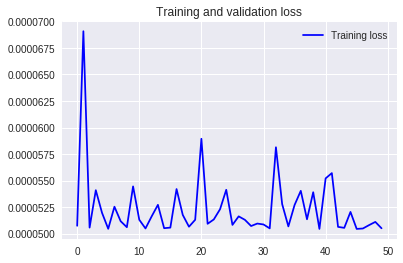

In [0]:
#train_mse = history.history['mse']
#validation_mse = history.history['val_mean_squared_error']
train_loss = history.history['loss']
#validation_loss = history.history['val_loss']

epochs = range(len(train_loss))

#plt.plot(epochs, train_mse, 'b-', label = 'Training MSE')
#plt.plot(epochs, validation_mse, 'r-', label = 'Validation MSE')
#plt.title('Training and validation MSE')
#plt.legend()

plt.figure()
plt.plot(epochs, train_loss, 'b-', label = 'Training loss')
#plt.plot(epochs, validation_loss, 'r-', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

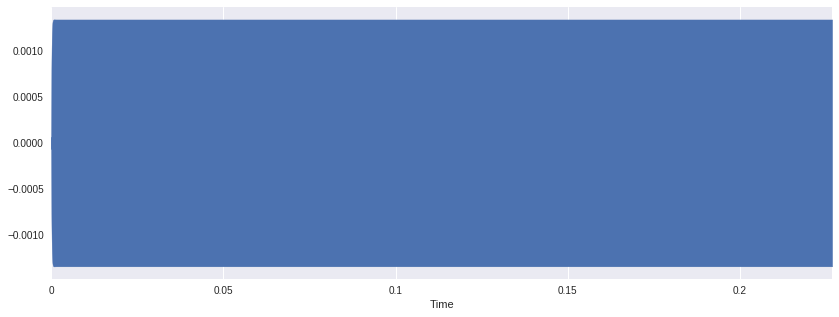

In [0]:
fig = plt.figure(figsize = (14, 5))
librosa.display.waveplot(Y_pred.flatten(), sr)